# SYSM 6302 - Lab 5
Jonas Wagner - jrw200000

In [1]:
import networkx as nx
import networkx.algorithms.community as nx_comm
from numpy import zeros, dot, array
import pickle
import matplotlib.pyplot as plt
import json
import string
import time
import numpy as np

#### Preq processing

In [2]:
import os.path
from os import path
if not path.exists('raw_twitter.json'):
    print('need to extract .json.zip file')    
if not path.exists('small_raw_twitter.json'):
    print('small version of raw_twitter does\'nt exist')

## Section 7.13: Modularity

The first function below calculates modularity for *directed* networks and also returns the maximum modularity value $Q_{\text{max}}$ (NetworkX's modularity function does not report the $Q_{\text{max}}$ value). The second function calculates scalar assortativity (NetworkX's assortativity functions differ from our book definition). 

In [3]:
def modularity(G,c):
    d = dict()
    for k,v in enumerate(c):
        for n in v:
            d[n] = k
    L = 0
    for u,v,data in G.edges.data():
        L += data['weight']
    Q, Qmax = 0,1
    for u in G.nodes():
        for v in G.nodes():
            if d[u] == d[v]:
                Auv = 0
                if G.has_edge(v,u):
                    Auv = G[v][u]['weight']
                Q += ( Auv - G.in_degree(u,weight='weight')*G.out_degree(v,weight='weight')/L )/L
                Qmax -= ( G.in_degree(u,weight='weight')*G.out_degree(v,weight='weight')/L )/L
    return Q, Qmax

def scalar_assortativity(G,d):
    x = zeros(G.number_of_nodes())
    for i,n in enumerate(G.nodes()):
        x[i] = d[n]

    A = array(nx.adjacency_matrix(G).todense().T)
    M = 2*A.sum().sum()
    ki = A.sum(axis=1) #row sum is in-degree
    ko = A.sum(axis=0) #column sum is out-degree
    mu = ( dot(ki,x)+dot(ko,x) )/M

    R, Rmax = 0, 0
    for i in range(G.number_of_nodes()):
        for j in range(G.number_of_nodes()):
             R += ( A[i,j]*(x[i]-mu)*(x[j]-mu) )/M
             Rmax += ( A[i,j]*(x[i]-mu)**2 )/M

    return R, Rmax

In [4]:
G = nx.read_weighted_edgelist('fifa1998.edgelist',create_using=nx.DiGraph)

c = {
    'group1': {'Argentina','Brazil','Chile','Mexico','Colombia','Jamaica','Paraguay'},
    'group2': {'Japan','SouthKorea'},
    'group3': {'UnitedStates'},
    'group4': {'Nigeria','Morocco','SouthAfrica','Cameroon','Tunisia','Iran','Turkey'},
    'group5': {'Scotland','Belgium','Austria','Germany','Denmark','Spain','France','GreatBritain','Greece','Netherlands','Norway','Portugal','Italy','Yugoslavia','Romania','Bulgaria','Croatia','Switzerland'}
    }
Q, Qmax = modularity(G,c.values())
print('FIFA exports by geographic region is assortatively mixed: %1.4f/%1.4f' % (Q,Qmax))

c = {
    'exporters': {'Argentina','Brazil','Chile','Colombia','Mexico','Scotland','Belgium','Austria','Denmark','France','Greece','Netherlands','Portugal','Yugoslavia','Croatia','Jamaica','Cameroon','Nigeria','Morocco','Tunisia'},
    'importers': {'Paraguay','SouthKorea','UnitedStates','SouthAfrica','Iran','Turkey','Germany','Spain','GreatBritain','Norway','Italy','Romania','Bulgaria','Switzerland','Japan'}
    }
Q, Qmax = modularity(G,c.values())
print('FIFA exports by importers/exporters is disassortatively mixed: %1.4f/%1.4f' % (Q,Qmax))

FIFA exports by geographic region is assortatively mixed: 0.1200/0.5505
FIFA exports by importers/exporters is disassortatively mixed: -0.0185/0.5748


#### Explination of Modularity Results
FIFA exports by region demonstrates more assortive mixing then that of the exporters vs importers assortativity. Although I don't know much about FIFA (I'm definetly an Americain Football guy), I expect their to be more connections between countries in the same regions then with teams on different parts of the world, so this would make sence for it to be more assortative. On the other hand, the classes of importers and exporters doesn't seem to have any particular reason for interconnection between thoose in the same group (considering the definition of an import/export) so disassortative mixing is the result.

## Section 7.13: Assortativity

In [5]:
gdp = pickle.load(open('gdp.pkl','rb'))
life_expectancy = pickle.load(open('life_expectancy.pkl','rb'))
tariff = pickle.load(open('tariff.pkl','rb'))

G = nx.read_weighted_edgelist('world_trade_2014.edgelist',create_using=nx.DiGraph)

R, Rmax = scalar_assortativity(G,gdp)
print('Assortativity by GDP: %1.4f' % (R/Rmax))
R, Rmax =  scalar_assortativity(G,life_expectancy)
print('Assortativity by life expectancy: %1.4f' % (R/Rmax))
R, Rmax =  scalar_assortativity(G,tariff)
print('Assortativity by tariff: %1.4f' % (R/Rmax))

Assortativity by GDP: -0.0005
Assortativity by life expectancy: 0.1281
Assortativity by tariff: 0.1191


#### Explination of Assortativity Results
The assortativity of trade based on GDP is near zero, indicating neither a assorative nor disortative mixing between contries of different GDP values. My guess as to why this is is becouse countries of higher GDP are not likely to only trade with other high GDP countries (it just wouldn't be smart) and similarily, small GDP countries would likely not trade any more with others with low GDP then thoose with Higher GDP.

There is a higher assortativity between life expectancy (the same as covariance/correlation) and the amount of trade between nations. This is possibly becouse nations of higher life expectancy would trade more for luxory goods or technology, while nations with lower life expectancy are not going to trade as much.

There also appears to be a correlation between average tarrif rates and the amount of trade between countries. This could posibly be due to the higher likelyhood of tarrifs to be placed on goods at a comparrable level to thoose of the nations you trade with.

#### Algebraic Manipulation of Covariance
(*This could be done on paper... but latex is just better... I also may or may not have already done this for another class*)

Let, $$\mu = \frac{1}{2m} \sum_{l = 1}^{n} k_l x_l$$
The Correlation is defined as:
$$R = \frac{1}{2m} \sum_{i=1}^{n} \sum_{j=1}^{n}
A_{ij} (x_i - \mu) (x_j - \mu)$$
This can then be expanded into
$$R = \frac{1}{2m} \sum_{i=1}^{n} \sum_{j=1}^{n}
A_{ij} (x_i x_j - x_i \mu - x_j \mu + \mu^2)$$
The definition of the $\mu$ can then be substituted in
$$R = \frac{1}{2m} \sum_{i=1}^{n} \sum_{j=1}^{n}
A_{ij} (x_i x_j 
- (x_i + x_j) (\frac{1}{2m} \sum_{l = 1}^{n} k_l x_l) 
+ (\frac{1}{2m} \sum_{l = 1}^{n} k_l x_l)^2)$$
This can then be expanded again into
$$R = \frac{1}{2m} \sum_{i=1}^{n} \sum_{j=1}^{n}(A_{ij} x_i x_j)\\
- \frac{1}{2m} \sum_{i=1}^{n} \sum_{j=1}^{n}(A_{ij}
(x_i + x_j) (\frac{1}{2m} \sum_{l = 1}^{n} k_l x_l))\\
+ \frac{1}{2m} \sum_{i=1}^{n} \sum_{j=1}^{n} A_{ij}
(\frac{1}{2m} \sum_{l = 1}^{n} k_l x_l)^2)
$$
And expanded again
$$R = \frac{1}{2m} \sum_{i=1}^{n} \sum_{j=1}^{n}(A_{ij} x_i x_j)\\
- \frac{1}{2m} \sum_{i=1}^{n} \sum_{j=1}^{n} A_{ij}(x_i)
(\frac{1}{2m} \sum_{l = 1}^{n} k_l x_l))\\
- \frac{1}{2m} \sum_{i=1}^{n} \sum_{j=1}^{n} A_{ij}(x_j)
(\frac{1}{2m} \sum_{l = 1}^{n} k_l x_l))\\
+ \frac{1}{2m} \sum_{i=1}^{n} \sum_{j=1}^{n} A_{ij}
(\frac{1}{2m})^2 (k_1^2 x_1^2 + k_1 k_2 x_1 x_2 + ... + k_n^2 x_n^2))
$$
and again (noting that the appropriete A_ij terms are encorporated into the expanded sum)
$$R = \frac{1}{2m} \sum_{i=1}^{n} \sum_{j=1}^{n}(A_{ij} x_i x_j)\\
- \frac{n^2}{(2m)^3}  (k_1^2 x_1^2 + k_1 k_2 x_1 x_2 + ... + k_n^2 x_n^2)\\
- \frac{n^2}{(2m)^3} (k_1^2 x_1^2 + k_1 k_2 x_1 x_2 + ... + k_n^2 x_n^2)\\
+ (\frac{1}{2m})^3 (k_1^2 x_1^2 + k_1 k_2 x_1 x_2 + ... + k_n^2 x_n^2))
$$
then eliminating the terms
$$R = \frac{1}{2m} \sum_{i=1}^{n} \sum_{j=1}^{n}(A_{ij} x_i x_j)\\
- (\frac{n}{2m})^3  (k_1^2 x_1^2 + k_1 k_2 x_1 x_2 + ... + k_n^2 x_n^2)
$$
then compacting (again remembering that the k_i k_j will be zero for the cases the A_ij is zero)
$$R = \frac{1}{2m} \sum_{i=1}^{n} \sum_{j=1}^{n}(A_{ij} x_i x_j)\\
- (\frac{n}{2m})^3 (\sum_{l = 1}^{n} k_l x_l)^2
$$
and again
$$R = \frac{1}{2m} \sum_{i=1}^{n} \sum_{j=1}^{n}(A_{ij} x_i x_j)\\
- \frac{1}{2m} \sum_{i=1}^{n} \sum_{j=1}^{n} (\frac{1}{2m} \sum_{l = 1}^{n} k_l x_l)^2
$$
and again
$$R = \frac{1}{2m} \sum_{i=1}^{n} \sum_{j=1}^{n}(A_{ij} x_i x_j) - (\frac{1}{2m} \sum_{l = 1}^{n} k_l x_l)^2
$$
and again
$$R = \frac{1}{2m} \sum_{i=1}^{n} \sum_{j=1}^{n}(A_{ij} x_i x_j) - \mu^2$$
which is equivelent to (clearly from the definition of \mu^2 being the full expanded sums again)
$$R = \frac{1}{2m} \sum_{i=1}^{n} \sum_{j=1}^{n}(A_{ij} - \frac{k_i k_j}{2m}) x_i x_j$$

## Sections 11.2-11.11: Community Detection

# ***Need to do the KL algorithm example drawing***
Tips:
- Go in reverse from perfect to scrambled and make the cut set larger... then how do you make it smaller again...

#### Modularity Matrix Summation Proof

Let,
$$B_{ij} = A_{ij} - \frac{k_i k_j}{2m}$$

When summing over all collums for a single row, the sum can be shown to be zero as follows
$$\sum_{j=1}^n B_{ij} 
= \sum_{j=1}^n A_{ij} - \frac{k_i k_j}{2m}\\
= \sum_math
$$

note... sum all row or collumn = degree of node

## Community Detection in Practice
Settings:

In [27]:
# Settings for running sections of community detection
small = ''#'small_' # 'small_' if small... '' if full
raw_tweets_filename = small + 'raw_twitter'
hashtag_sets_filename = small + 'hashtag_sets'
edgelist_filename = small + 'edgelist'
htag_comms_filename = small + 'htag_communities'
#use small_raw_twitter and small_hashtag_sets for speed

# Run sections
json_2_raw_tweets = not path.exists(raw_tweets_filename + '.txt')
raw_tweets_2_hashtag_sets = not path.exists(hashtag_sets_filename + '.txt')
build_network = not path.exists(edgelist_filename + '.edgelist')
find_communities_original = False # Don't run... not needed... not path.exists(htag_comms_filename + '_original' + '.txt') 
find_communities_w10_c10 = not path.exists(htag_comms_filename + '_w10_c10' + '.txt')

#### Twitter Network Conceptual Questions
The idea of linking hashtags together by when they occur together in a tweet could describe the similarity between them as they are used together on the same message. This would potray a similar feeling/tone or related topics of interest.
An example of this would be the use of #fml and #disapointed. In tweets when they are used together they likely are used to describe the feeling dispair or sadness that refer to the contents of the tweet.
An example that is not as useful would be when two hashtags are used in a tweet as polar opesites, i.e. #Good vs #Bad, or #Fire vs #Water

#### Functions for dealing with tweets
*** It is getting anoying to have to do this more complicated in a jupyter notebook... I'm looking foward to doing it all with scripts for my project

In [7]:
def readJSON2List(filename):
    """
    this reads a raw json, selects only the english tweets
    and saves text to a list of strings
    """
    fp = open(filename + '.json', 'r', encoding='utf-8')
    tweets = []
    for line in fp:
        if len(line) > 2:
            line_data = json.loads(line)
            if line_data['lang'] == 'en': # only english
                tweets.append(line_data['text'])
    
    return tweets

In [8]:
def readTxt2List(filename, deliminator = '\n uniqueDeliminator \n'):
    """
    reads from outputed txt list into a python list
    """
    print('not coded...')
    return -1

In [9]:
def writeList2txt(tweets, filename, deliminator = '\n uniqueDeliminator \n'):
    """
    this writes a list of tweets to a txt file
    """
    with open(filename + '.txt', 'w', encoding = 'utf-8') as filehandle:
        for tweet in tweets:
            filehandle.write(str(tweet) + deliminator)

In [10]:
import re
def tweetTextAnalysis(tweet):
    """
    takes tweet text (as a string) and processes it...
    1) strip
    2) lowercase
    3) hashtag search
    4) return list of hashtags (withough #)
    """
    if '#' in tweet:
        tweet = tweet.strip()
        tweet = tweet.lower()
        regex = "#(\w+)"
        hashtags = sorted(re.findall(regex, tweet))
        if len(hashtags) == 0:
            hashtags = -1
    else:
         hashtags = -1   
    return hashtags

In [11]:
def findHashtags(tweets):
    """
    This interprits the list of tweets (english and post striping of json stuff)
    and finds the co-occuring hashtags
    """
    Hashtags = [str]
    for tweet in tweets:
        hashtags = tweetTextAnalysis(tweet)
        if type(hashtags) == list:
            if len(hashtags) > 1:
                Hashtags.append(hashtags)
    return Hashtags

In [12]:
import collections
from itertools import combinations
def findHashtagPairs(Hashtags):
    """
    This takes a list of hashtags in tweets and finds a histagram of pairs
    (it ignores single hashtag tweets)
    """
    Pairs = []
    for hashtags in Hashtags:
        if type(hashtags) != list:
            continue
        if len(hashtags) == 2:
            Pairs.append(tuple(hashtags))
        elif len(hashtags) >= 3:
            for pair in combinations(hashtags,2):
                Pairs.append(tuple(pair))
    uniquePairs = collections.Counter(Pairs)
    return uniquePairs

### Functions for building and analyzing networks

In [13]:
def buildNetworkFromPairs(hashtagPairs, G = nx.Graph()):
    """
    Builds Network from pairs of hashtags
    """
    for pair in hashtagPairs:
        i = hashtagPairs[pair[0],pair[1]]
        G.add_edge(pair[0],pair[1],weight=i)
    return G

In [14]:
def findCommunities(G):
    """
    Finds Communities in the network and return as a list
    """
    return list(nx_comm.label_propagation_communities(G))

In [15]:
def removeSmallEdges(G, threshold = 10, weightProperty = 'weight'):
    """
    Removes edges with weight below threshold
    """
    G_temp = nx.Graph(G)
    for edges in G_temp.edges():
        if G_temp[edges[0]][edges[1]][weightProperty] < threshold:
            G_temp.remove_edge(*edges)
    return G_temp

In [41]:
def removeSmallComponents(G, threshold = 10):
    """
    Removes components with weight below threshold
    """
    G_temp = nx.Graph(G)
    for component in list(nx.connected_components(G_temp)):
        if len(component) < threshold:
            for node in component:
                G_temp.remove_node(node)
    return G_temp

In [65]:
def analyzeGraphCommunities(G, weightThreshold, componentThreshold,
                            htag_comms_filename,
                            ax = -1):
    # Copy graph
    G_temp = nx.Graph(G)
    # Edge Threshold
    G_w = removeSmallEdges(G_temp, threshold = weightThreshold, weightProperty = 'weight')
    # Component Threshold
    G_w_c = removeSmallComponents(G_w, threshold = componentThreshold)
    # Find cset
    cset = findCommunities(G_w_c)
    # Save cset
    writeList2txt(cset,
                  htag_comms_filename + '_w'
                  + str(weightThreshold) + '_c' + str(componentThreshold),
                  deliminator = '\n')
    # Calculate Community Sizes:
    comm_sizes = []
    for comm in cset:
        comm_sizes.append(len(comm))
    # Plot Histagram
    if type(ax) == int:
        fig, ax = plt.subplots()
    ax.hist(comm_sizes,20)
    ax.set_title('G_w' + str(weightThreshold) + '_c' + str(componentThreshold))

### 1) Identifying co-occuring hashtags in data

1. Use JSON to output tweet data directly into a text file: raw_tweets.txt

In [17]:
#JSON 2 Raw Tweets
if json_2_raw_tweets:
    tweets = readJSON2List(raw_tweets_filename)
    writeList2txt(tweets, raw_tweets_filename)
else:
#     tweets = readTxt2List(raw_tweets_filename) #isn't coded yet
    tweets = readJSON2List(raw_tweets_filename)

2. Use raw_tweets.txt to produce a list of space-deliminated list of hashtages in tweets: hashtag_sets.txt

In [18]:
# Raw tweets to hashtag pairs
if raw_tweets_2_hashtag_sets:
    Hashtags = findHashtags(tweets)
    writeList2txt(tweets, hashtag_sets_filename, deliminator = '\n')
else:
    #reading directly not done yet
    Hashtags = findHashtags(tweets)
    writeList2txt(tweets, hashtag_sets_filename, deliminator = '\n')

hashtagPairs = findHashtagPairs(Hashtags)

#### Empty line explination
All of the empty lines (that I didn't purposly add) within the hashtag_sets.txt file indicate that no hashtags were included in the respective tweet. (I didn't actually follow this structure when creating mine though as I preproccessed to only include english and didn't write the empty lines to the file.)

### 2) Building a network from co-occuring hashtags

**Note:** The file hashtag_sets.txt can be interpreted as a hypergraph network as each line (tweet) being a node and the hashtags being the associated groups that they are associated with. Analysis of this network doesn't provide us with as much information about the combination of hashtags being together (i.e. they aren't the nodes of the network as we want)

1. Create an empty weighted undirected network.
2. Read in each sets of hashtags and create nodes (hashtags) and an edge linking them (or increase the weight of existing edges).
3. Use the generated network and save it as an .edgelist file.

In [19]:
if build_network:
    # Steps 1 and 2 done in function
    G = buildNetworkFromPairs(hashtagPairs)
    # Save to an edgelist file:
    nx.write_edgelist(G, edgelist_filename + '.edgelist')
else:
    G = nx.read_edgelist(edgelist_filename + '.edgelist')

### 3) Detecting communities in the network

1. Use the nx_comm.label_propagation_communities to create a list of the community sets

In [25]:
if find_communities_original:
    cset = findCommunities(G)
    writeList2txt(cset, htag_comms_filename + '_original', deliminator = '\n')

### 4) Finding the most meaningful communiites
Analysis withough preprocessing doesn't give as much detailed information... so a few things should do make it more meaningful.

#### Methods:
1. Introducing a weighting threashold on network edges

Ignoring the low weighted edges essentially means that a certain number of tweets are required to share hashtags before they are considered connected. Raising the threshold higher will gradually restrict the hashtags that are linked to thoose that are used together very frequently. It would also eliminate the connections for lesser used hashtags as they are less likely to have enough tweets to overcome the threshold.

In [21]:
# Weighting Threshold Implimentation
G_w10 = removeSmallEdges(G, threshold = 10, weightProperty = 'weight')

2. Eliminating smaller connected components of the graph

By eliminating connected components you would be able to better focus on the more prevelent hashtags and their relationship with each other. This would also eliminate outlier hashtags that may be mispelled or just not very common. By doing this though (depending on if a weighting threshold was already implimented) very niche hashtags and combinations that could very well be very often used with other hashtags, but not the main ones, would be eliminated.

In [26]:
# Smaller Component Elimination
G_w10_c10 = removeSmallComponents(G_w10, threshold = 10)

3. Save communities of hashtags as a text file

In [38]:
# Saving Communities
if find_communities_w10_c10:
    cset = findCommunities(G_w10_c10)
    writeList2txt(cset, htag_comms_filename + '_w10_c10', deliminator = '\n')
else:
    # Nothing special coded
    cset = findCommunities(G_w10_c10)

#### Histagram plot of community sizes

In [39]:
# Calculate Community Sizes:
comm_sizes = []
for comm in cset:
    comm_sizes.append(len(comm))

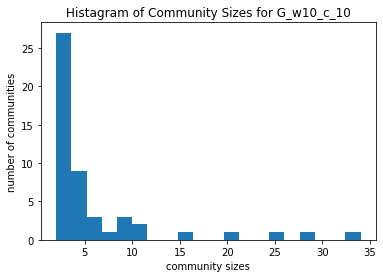

In [40]:
# Plot Histagram
plt.hist(comm_sizes,20)
plt.xlabel('community sizes')
plt.ylabel('number of communities')
plt.title('Histagram of Community Sizes for G_w10_c_10')
plt.show()

**Analysis of histagram:**

This histogram shows that there is only a few communities with greater then 10 hashtags but there are a lot of smaller communities that still exist within the graph.

#### Analysis of certain community examples

**Make sense examples:**

Two examples of communties that make sense are one relating to cooking and one related to adult topics:
1. {'baking', 'cooking', 'food', 'recipes', 'foodporn', 'desserts'}
2. {'hardcore', 'nsfw', 'celebrities', 'sexy', 'porn', 'celebrity', 'anal', 'video', 'bokep', 'milf', 'ngentot', 'jav', 'sex', 'livegirls', 'hot', 'asian', 'bisyar', 'xxx', 'free', 'teen', 'adult'}

In the first community, each hashtag relates to food and probably exist as hashtags with photos of baked goods or cooking. Similarly, the secound community all include hashtags that are related to the adult industy and likely were included in promotional posts for pornographic or other adult websites.

**Don't make sense examples:**

Two examples of communties that don't make as much sense are as follows:
1. {'kindlepricedrop', 'pinof7', 'jesuisdinde', 'imthankfulfor'}
2. {'mtvhitsla', 'sorry', 'illshowyou'}

In these communities there really doesn't appear to be much of a connection between them, eventhough they would have had to appear with each other in (at least 10) tweets to be connected.

### Quality Analysis
Many communities were generated for the graph using different threshold values for minimum weight and cluster size

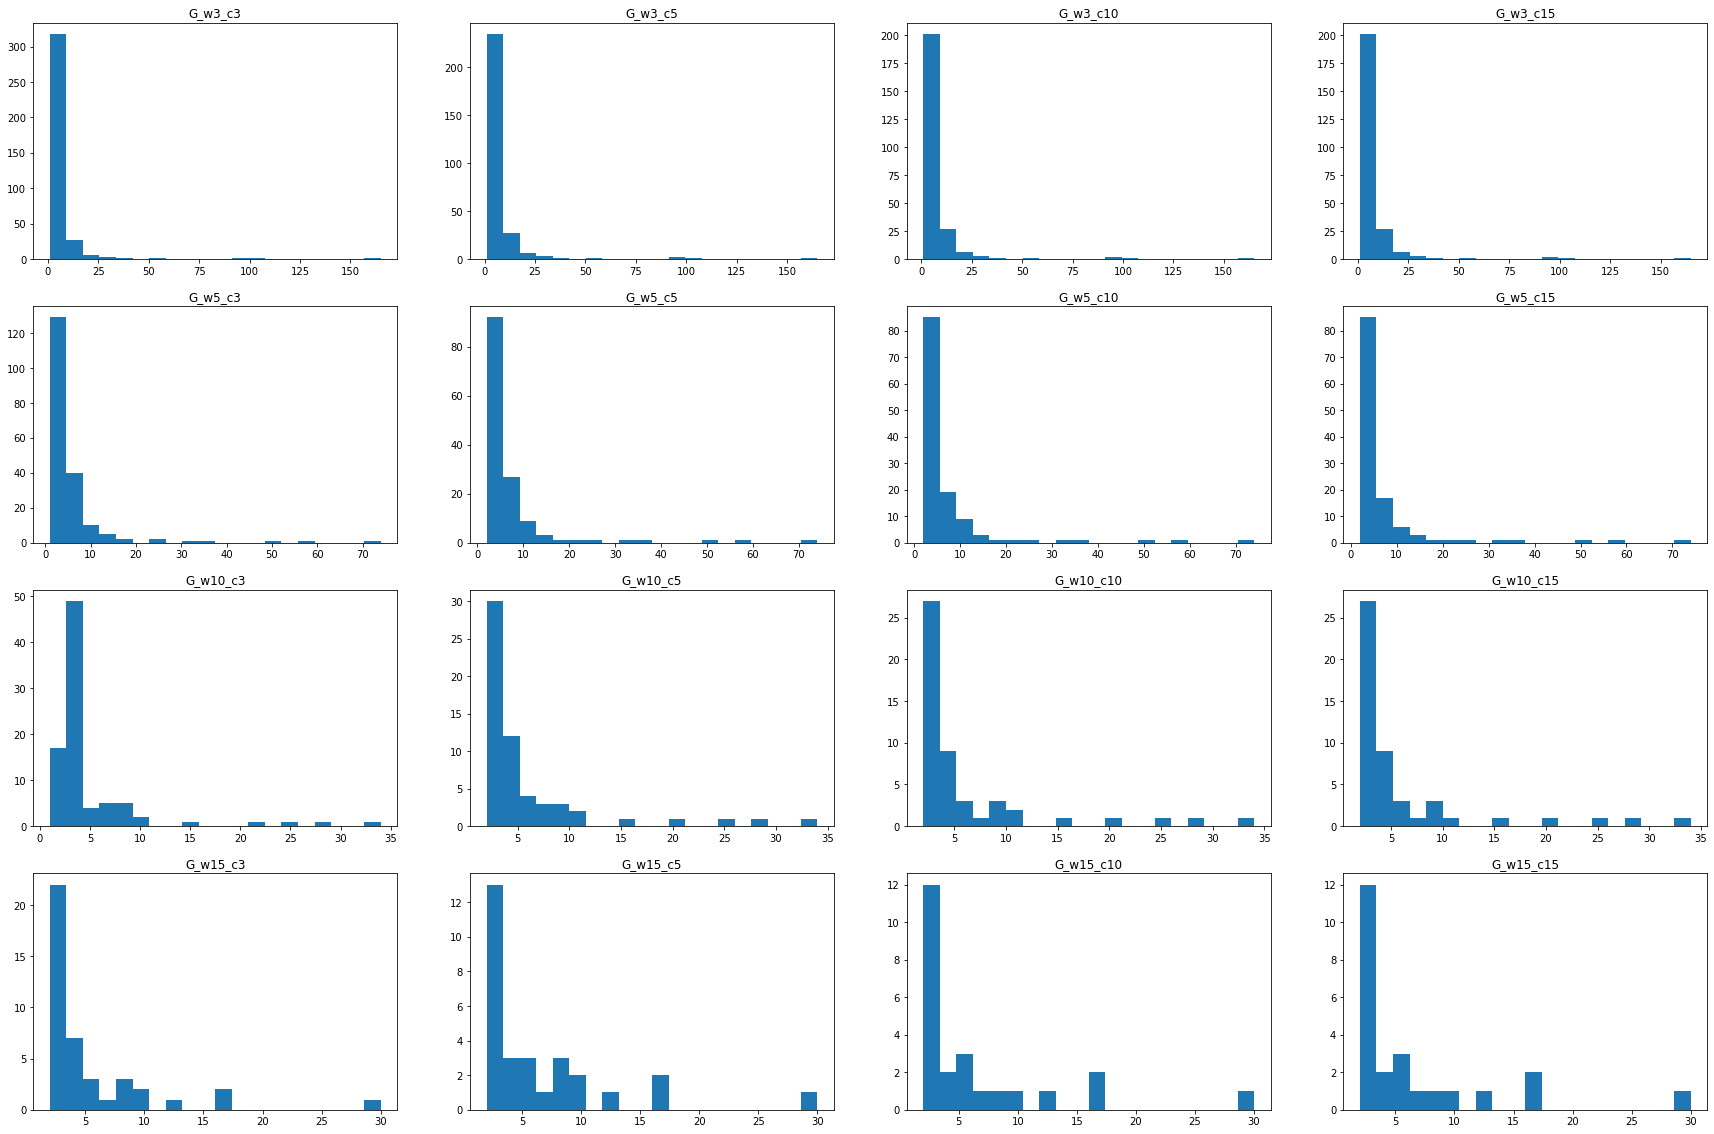

In [67]:
# Generating communities dependent on w and c
W = [3, 5, 10, 15]
C = [3, 5, 10, 15]
fig, axes = plt.subplots(len(W),len(C), figsize=[30,20])
for i, w in enumerate(W):
    for j, c in enumerate(C):
        analyzeGraphCommunities(G, w, c, htag_comms_filename, axes[i][j])
plt.show()

#### Setting affect comparrision
|   |Weight threshold Low (3)  | Weight threshold High (15)|
|------------------------------|:---:|:--:|
| Component threshold Low  (3) |  Q1 | Q2 |
| Component threshold High (15)|  Q3 | Q4 |

Considering the given table with the threshold values being the extreames generated (3 and 15) a few insights can be made about the strengths and weackness of each.


|    |            Strengths              |         Weaknesses                 |
|----|:---------------------------------:|:----------------------------------:|
|Q1  |Doesn't eliminate many hashtags    |A lot of communities (some split up)|
|    |                                   |Some strangler communities          |
|Q2  |Mostly relevent hashtag communities|Large and little # of communities   |
|    |                                   |A lot of hashtags eliminated        |
|Q3  |Doesn't eliminate many hashtags    |Many split up related groups        |
|    |Very relevent hashtag communities  |   A lot of stranglers              |
|Q4  |Mostly relevent hashtag communities|A lot of hashtags eliminated        |
|    |                                   |Very large communities (restricted) |

**Big Takeaways:**
- Increasing the weighting threshold eliminates a lot of hashtags that are only interconnected with a small number of hashtags. This greatly decreases the number of hashtag communities (which can be good or bad)
- Increasing the component threshold eliminates a lot of strangler communities (which also restricts them).

**Q1:**

This one is full of hashtags, but many of the communities are smaller strangler groupings that aren't always relevent.

Some strangler examples:
- {'my'}
- {'hq', 'new'}
- {'slut', 'plump'}

Some good full (and relevent) communities:
- {'entrepreneur', 'growthhacking', 'entrepreneurs', 'entrepreneurship', 'smallbiz', 'success'}
- {'indiegames', 'game', 'madewithunity', 'gamersunite', 'indiegame', 'pixelart', 'breakingnews', 'gaming', 'cyborgrage', 'takosan', 'iosdev', 'indiedev', 'gamedev', 'retrogaming', 'gamedesign', 'parisattack', 'indie'}
- {'slutty', 'ethnic', 'kinky', 'sexy', 'hentai', 'dressedundressed', 'wetrixxx', 'webcam', 'toket', 'fucking', 'interracial', 'fatty', 'bigtit', 'pictures', 'bbw', 'livegirls', 'blowjob', 'asian', 'employment', 'blonde', 'boobs', 'fuck', 'selfshot', 'chubby', 'ebony', 'model', 'nsfw', 'hairy', 'celebrities', 'pussy', 'women', 'hd', 'beauty', 'escorts', 'booty', 'video', 'babe', 'ngentot', 'tits', 'earnmoney', 'sex', 'twitterafterdark', 'bisyar', 'free', 'xxx', 'amateur', 'teen', 'adult', 'hardcore', 'fetish', 'girls', 'indian', 'lesbian', 'porn', 'celebrity', 'hotteen', 'freeporn', 'milf', 'sexgif', 'tv', 'handjob', 'jav', 'fappmail', 'horny', 'porngif', 'hot', 'nude', 'pornstar', 'traffic', 'models', 'fingering', 'porno', 'girlfriend', 'doll', 'bigtits', 'naked', 'blondeteen', 'topless', 'lbfm', 'shavedpussy', 'bondage', 'softcore', 'sexvideo', 'anal', 'bokep', 'blondes', 'privatepics', 'movie', 'ass', 'bigboobs', 'gossip', 'big', 'bush', 'brunette', 'cumshot', 'bdsm'}

**Q2:**

This one is a lot more restrictive, but for the most part they are relevent but smaller versions of communities comparred to Q1 or Q3.

Some strangler (and relevent) examples:
- {'christmas', 'gift'}
- {'blessed', 'thankful'}
- {'3', '1', '2'}

Some good and relevent (but restrictive) communities:
- {'androidgames', 'gameinsight', 'iphone', 'ipadgames', 'ipad', 'paradiseisland2', 'android', 'apple', 'iphonegames'}
- {'casino', 'usa', 'unitedstates', 'resort', 'travel'}
- {'jav', 'nsfw', 'sex', 'porn', 'ngentot', 'livegirls', 'hot', 'anal', 'bokep', 'teen', 'xxx', 'sexy', 'adult'}

**Q3:**

This one doesn't eliminate a lot of hashtags, but does have a lot of smaller strangler communities that sometimes don't appear relevent.

Some small or split up examples:
- {'my'}
- {'5', '1'} & {'awkward', '2'} & {'arrow', '4'} & {'3', '찬열아생일축하해', 'happyvirusday', 'happychanyeolday'}

Some large relevent examples:
- {'cock', 'gay', 'gayarab', 'gayporn', 'videogay', 'bigcock', 'ttbm', 'weshcousin', 'beurgay', 'citebeur', 'gaysex', 'twink'}
- {'children', 'how', 'to', 'crockpot', 'handicrafts', 'organic', 'food', 'kids', 'son', 'spanish', 'recipes', 'desserts', 'baking', 'cutie', 'cooking', 'daughter', 'baby', 'make', 'delicious'}
- {'slutty', 'ethnic', 'kinky', 'sexy', 'hentai', 'dressedundressed', 'wetrixxx', 'webcam', 'toket', 'fucking', 'interracial', 'fatty', 'bigtit', 'pictures', 'bbw', 'livegirls', 'blowjob', 'asian', 'employment', 'blonde', 'boobs', 'fuck', 'selfshot', 'chubby', 'ebony', 'model', 'nsfw', 'hairy', 'celebrities', 'pussy', 'women', 'hd', 'beauty', 'escorts', 'booty', 'video', 'babe', 'ngentot', 'tits', 'earnmoney', 'sex', 'twitterafterdark', 'bisyar', 'free', 'xxx', 'amateur', 'teen', 'adult', 'hardcore', 'fetish', 'girls', 'indian', 'lesbian', 'porn', 'celebrity', 'hotteen', 'freeporn', 'milf', 'sexgif', 'tv', 'handjob', 'jav', 'fappmail', 'horny', 'porngif', 'hot', 'nude', 'pornstar', 'traffic', 'models', 'fingering', 'porno', 'girlfriend', 'doll', 'bigtits', 'naked', 'blondeteen', 'topless', 'lbfm', 'shavedpussy', 'bondage', 'softcore', 'sexvideo', 'anal', 'bokep', 'blondes', 'privatepics', 'movie', 'ass', 'bigboobs', 'gossip', 'big', 'bush', 'brunette', 'cumshot', 'bdsm'}

**Q4:**

This one is very restrictive and only includes a small fraction of what the others do, but it is mostly relevent with a few split up.

Some relevent smaller communities (a lot of these):
- {'russia', 'isis', 'syria', 'turkey'} *Note: Turkey probably had a double meaning w/ thanksgiving, so I thought it was weird to be paired here... although this was the time Trump was dealing with syria/isis right..
- {'christmas', 'gift'}
- {'photo', 'photooftheday'}

Some split up/mixed up sets:
- {'news', 'howto', 'apps', 'advertising', 'startups'} & {'startup', 'business', 'money'}
- {'happythanksgiving', 'iamthankfulfor', 'matwh'} & {'blessed', 'thankful'}
- {'amateur', 'softcore', 'nude'} & {'jav', 'nsfw', 'sex', 'porn', 'ngentot', 'livegirls', 'hot', 'anal', 'bokep', 'teen', 'xxx', 'sexy', 'adult'}

### Topic Disscussion
Looking at the topic of thanksgiving football (so the Panthers @ Cowboys, Eagles @ Lions, and Bears @ Packers).
Another note is that this data was taken on Thanksgiving 2015 at around 3:30-4pm central time (2015-11-26 21:30 - 22:00 UTC). This lines up in the middle of the panthers and cowboys game that saw the panthers beat the cowboys (33-14) and the panthers in the lead the entire game.
It is also important to note that the Eagles and Lions played about 4 hours prior (with a 14-45 Lions win).
The other thing is that the Packers and Bears have a big rivalry (F**k da Bears!) that was an close upset won by the bears in the 4th quarter (17-13), so the lead up to this theoretically would be big.

Looking at the tweet data we can see a few different catagories for the 4 extreames:

**Q1:** One good chunck with the panthers and cowboys game... but then a lot of it is just scattered (and not connected to each other) through a lot of others less related topics
- Panthers @ Cowboys game: {'gopanthers', 'cowboysvspanthers', 'pick6', 'nflthanksgiving', 'luuuuke', 'panthers', 'kurtcoleman', 'cowboys', 'dabonthemturkey', 'camnewton', 'wedemboyz', 'cowboysnation', 'fieldgoal', 'keeppounding', 'panthersnation', 'chivsgb', 'panthernation', 'interception', 'colorrush', 'wfaacowboys', 'gocowboys', 'dc4l', 'romo', 'touchdown', 'dalvscar', 'picksix', 'americasteam', 'carvsdal', 'peytonmanning', 'dallascowboys'}
- Packers: {**'packers'**, 'heat', 'th4nksgiving', 'twit'}
- Bears: {'bears', 'chicagobears'}
- Eagles: {**'eagles'**, 'opseaworld', 'seaworld'}
- General Thanksgiving (panthers and lions highlighted): {'thankfulselfie', 'recipe', 'ebook', 'giftguide', 'uncles', 'happyholidays', 'praise', 'telenovela', 'utah', 'tagsforlikes', 'holidays', 'holiday', 'thanksliving', 'thanksgivingwithnativefamilies', 'gobblegobble', 'nato', 'thanksgiving2015', 'thewalkingdead', 'funnyjpegs', 'blackfridaydeals', 'happyturkeyday', 'macysthanksgivingparade', 'fallout4', 'egypt', 'wine', 'iamthankfulfor', 'turkeyday', 'dinner', 'nofilter', 'giving', 'sunset', 'happythanksgiving', 'greysanatomy', 'friends', 'dessert', 'berniesanders', 'qbochat', 'happythankgiving', 'deepfriedturkey', 'peace', 'beautiful', **'carolinapanthers'**, 'america', **'lions'**, 'pie', 'polksgiving', 'cool', 'family', 'stuffed', 'whyimthankful', 'nyc', 'life', 'fun', 'thursday', 'blessed', 'ootd', 'godbless', 'grateful', 'theopening', 'american', 'ha', 'thanksgivingday', 'heart', 'i', 'foodcoma', 'teens', 'thanksgiving', 'lgm', 'lyfetea', 'friendsgiving', 'givingback', 'happy', 'joy', 'housefull', 'seniorday', 'thanks', 'manhattan', 'love', 'thanksgivingdinner', 'familytime', 'russianjet', 'masterofnone', 'murica', 'joytrain', 'twd', 'matwh', 'happythanksgivingeveryone', 'allaboutlove', 'kickstarter', 'gratitude', 'yearinspace', 'thankfulfor', '2015', 'sidedishes', 'turkey', 'adoptdontshop', 'thankyou', 'givethanks', 'thankful', 'faith'}
- NFL: {'jersey', 'dfsplaybookpro', 'cfb', 'nba', 'espn', 'nhl', **'nfl'**, 'basketball', 'hockey', 'saints', 'sportsbetting'}
- Football: {'redskins', 'soccer', 'reebok', **'football'**}

**Q2:**
Extreamly limited number of hashtags and restrictive to only the Panthers/Cowboys game (which was occuring during the time window)
- Panthers @ Cowboys game: {'colorrush', 'keeppounding', 'carvsdal', 'nflthanksgiving', 'panthers', 'nfl', 'cowboys', 'football'}
- Game hashtags: {'dalvscar', 'cowboysnation'} *Note: #dalvscar is just backwards... compared to #carvsdal

**Q3:** Very Very similar results to Q1. A lot of scattered... but some stangler changes
- Panthers @ Cowboys game: {'gopanthers', 'cowboysvspanthers', 'pick6', 'nflthanksgiving', 'luuuuke', 'panthers', 'kurtcoleman', 'cowboys', 'dabonthemturkey', 'camnewton', 'wedemboyz', 'cowboysnation', 'fieldgoal', 'keeppounding', 'panthersnation', 'chivsgb', 'panthernation', 'interception', 'colorrush', 'wfaacowboys', 'gocowboys', 'dc4l', 'romo', 'touchdown', 'dalvscar', 'picksix', 'americasteam', 'carvsdal', 'peytonmanning', 'dallascowboys'}
- Packers: {**'packers'**, 'heat', 'th4nksgiving', 'twit'}
- Bears: {'bears', 'chicagobears'}
- Eagles: {**'eagles'**, 'opseaworld', 'seaworld'}
- General Thanksgiving: {'thankfulselfie', 'recipe', 'ebook', 'giftguide', 'uncles', 'happyholidays', 'praise', 'telenovela', 'utah', 'tagsforlikes', 'holidays', 'holiday', 'thanksliving', 'thanksgivingwithnativefamilies', 'gobblegobble', 'nato', 'thanksgiving2015', 'thewalkingdead', 'funnyjpegs', 'blackfridaydeals', 'happyturkeyday', 'macysthanksgivingparade', 'fallout4', 'egypt', 'wine', 'iamthankfulfor', 'turkeyday', 'dinner', 'nofilter', 'giving', 'sunset', 'happythanksgiving', 'greysanatomy', 'friends', 'dessert', 'berniesanders', 'qbochat', 'happythankgiving', 'deepfriedturkey', 'peace', 'beautiful', **'carolinapanthers'**, 'america', **'lions'**, 'pie', 'polksgiving', 'cool', 'family', 'stuffed', 'whyimthankful', 'nyc', 'life', 'fun', 'thursday', 'blessed', 'ootd', 'godbless', 'grateful', 'theopening', 'american', 'ha', 'thanksgivingday', 'heart', 'i', 'foodcoma', 'teens', 'thanksgiving', 'lgm', 'lyfetea', 'friendsgiving', 'givingback', 'happy', 'joy', 'housefull', 'seniorday', 'thanks', 'manhattan', 'love', 'thanksgivingdinner', 'familytime', 'russianjet', 'masterofnone', 'murica', 'joytrain', 'twd', 'matwh', 'happythanksgivingeveryone', 'allaboutlove', 'kickstarter', 'gratitude', 'yearinspace', 'thankfulfor', '2015', 'sidedishes', 'turkey', 'adoptdontshop', 'thankyou', 'givethanks', 'thankful', 'faith'}
- Football: {'redskins', 'soccer', 'reebok', **'football'**}
- Football: {**'nflfootball'**, 'yahoosports'}

**Q4:** 
Very Very restrictive... Only the one community without a lot of info about anything besides just the (likely) trending hashtags related to the panthers @ cowboys game.
- {'colorrush', 'keeppounding', 'carvsdal', 'nflthanksgiving', 'panthers', 'nfl', 'cowboys', 'football'}



#### Best Solution for Topic
Of the 4 extreams, the best would probably be Q1 or Q3 becouse it included a lot of the important (and relevent) hashtags within one community while still having the other hashtags included as well. However, many of the intermediate settings resulted in better results.

The best weight threshold that was tested appears to be 5. The components threshold didn't appear to have much of an effect on these groups, but setting the componet threshold to 15 eliminated much of the unrelated stranglers in the network.
Although this does eliminate multiple (less frequent) hashtags, the communities are reaaranged to some more meaningful sets, including:
- NFL Thanksgiving: {'sports', 'jersey', 'fieldgoal', 'dalvscar', 'carvsdal', 'nflthanksgiving', 'chivsgb', 'panthers', 'espn', 'nfl', 'cowboys', 'dabonthemturkey', 'th4nksgiving'}
- Cowboys: {'dallascowboys', 'gocowboys', 'cowboysnation', 'wedemboyz'}
- Panthers: {'gopanthers', 'keeppounding', 'panthernation', 'luuuuke', 'colorrush'}
- Packers v Bears: {'packers', 'bears'}
- Lions v Eagles: {'lions', 'eagles'}

From looking at these very well laid out (and pretty complete) communities it is clear that these settings are great for grouping hashtags related to this topic.